<a href="https://colab.research.google.com/github/sarbol/NumericalReasoningModels/blob/main/ConFinQA_Results_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install --upgrade tiktoken -q
%pip install --upgrade openai -q

In [2]:
from transformers import (pipeline,
                          RobertaTokenizer,
                          RobertaConfig,
                          AutoModelForCausalLM,
                          AutoTokenizer)
from google.colab import drive
from google.colab import userdata
from openai import OpenAI
import os
import tiktoken
import tqdm
import torch
import numpy as np
from sympy import simplify
import operator
import collections
from jinja2 import Template
import json
import os
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union
from IPython.display import HTML
from datetime import datetime
import time
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_PATH = "/content/drive/MyDrive/ConvFinQA/data/"

RESULT_DIR = "/content/drive/MyDrive/ConvFinQA/output/generator-roberta-large-2e-5-new-test_20250324083557/results/loads/20/valid"

In [5]:
with open(os.path.join(DATA_PATH, "dev_turn.json")) as f:
  validation_data = json.load(f)

with open(os.path.join(RESULT_DIR, "nbest_predictions.json"), "r") as f:
  nbest_predictions = json.load(f)

In [6]:
def detokenize(tokens):
  operations = []
  stack = []
  valid_const_pattern = re.compile(r'^(const_[1-9]|const_10+|const_m1|\^?\d+)$')
  valid_number_pattern = re.compile(r'^-?\d*(\.\d+)?[%]*?$')  # Allows .456, -.456, 123, -123.45, etc.

  i = 0
  while i < len(tokens):
      token = tokens[i]

      if re.match(r'^[a-zA-Z_]+\($', token):  # Match operation name (e.g., 'subtract(')
          stack.append(token)
      elif valid_number_pattern.match(token) or token.startswith('#') or valid_const_pattern.match(token):  # Match valid arguments
          stack.append(token)
      elif token == ')':  # Closing bracket
          if len(stack) < 3:
              raise ValueError("Malformed expression: An operation must have two arguments.")

          arg2 = stack.pop()
          arg1 = stack.pop()
          operation = stack.pop()

          if not operation.endswith('('):
              raise ValueError(f"Invalid operation format: {operation} should end with '('")

          op_name = operation[:-1]  # Remove '('
          formatted_op = f"{op_name}({arg1}, {arg2})"
          operations.append(formatted_op)
          stack.append(f"#{len(operations) - 1}")  # Store reference
      elif token == 'EOF':
          break
      else:
          raise ValueError(f"Invalid token detected: {token}")

      i += 1

  # Ensure no standalone numbers or invalid constants exist in final output
  for item in stack:
      if not item.startswith('#') and not re.match(r'^[a-zA-Z_]+\(.*\)$', item):
          raise ValueError(f"Invalid standalone value detected: {item}")

  return ", ".join(operations)

In [7]:
def equal_program(program1, program2):
    '''
    Symbolic program equality check (non-recursive version)
    program1: gold program
    program2: predicted program
    '''
    all_ops = ["add", "subtract", "multiply", "divide", "exp", "greater"]

    # Remove EOF marker
    program1 = program1[:-1]
    program2 = program2[:-1]

    # Single number program special case
    if len(program1) == 1:
        return len(program2) == 2 and program1[0] == program2[0]

    # Symbolic mapping preparation
    sym_map = {}
    sym_ind = 0

    # First pass: create symbolic mapping
    def create_symbolic_mapping(program):
        nonlocal sym_map, sym_ind
        program_str = "|".join(program)
        steps = program_str.split(")")[:-1]
        step_dict = {}

        # Validate program structure
        for ind, token in enumerate(program):
            if ind % 4 == 0:
                if token.strip("(") not in all_ops:
                    return None
            if (ind + 1) % 4 == 0:
                if token != ")":
                    return None

        # Process steps and create symbolic mapping
        for ind, step in enumerate(steps):
            step = step.strip()

            if len(step.split("(")) > 2:
                return None

            op = step.split("(")[0].strip("|").strip()
            args = step.split("(")[1].strip("|").strip()

            if args.count("|") != 1:
                return None

            arg1 = args.split("|")[0].strip()
            arg2 = args.split("|")[1].strip()

            step_dict[ind] = step

            # Symbolic mapping for steps
            if "table" in op:
                if step not in sym_map:
                    sym_map[step] = f"a{sym_ind}"
                    sym_ind += 1
            else:
                # Map arguments to symbols
                for arg in [arg1, arg2]:
                    if "#" not in arg:
                        if arg not in sym_map:
                            sym_map[arg] = f"a{sym_ind}"
                            sym_ind += 1

        return step_dict

    # Validate and create symbolic mapping for first program
    step_dict_1 = create_symbolic_mapping(program1)
    if step_dict_1 is None:
        return False

    # Reset for second program
    sym_map = {}
    sym_ind = 0

    # Validate and create symbolic mapping for second program
    step_dict_2 = create_symbolic_mapping(program2)
    if step_dict_2 is None:
        return False

    # Symbolic evaluation function
    def symbolic_evaluate(step, step_dict):
        step = step.strip()
        op = step.split("(")[0].strip("|").strip()
        args = step.split("(")[1].strip("|").strip()

        arg1 = args.split("|")[0].strip()
        arg2 = args.split("|")[1].strip()

        # Handle table operation
        if "table" in op:
            return sym_map[step]

        # Resolve arguments
        def resolve_arg(arg):
            if "#" in arg:
                arg_ind = int(arg.replace("#", ""))
                # Recursively resolve referenced steps
                step_to_resolve = step_dict[arg_ind]
                return symbolic_evaluate(step_to_resolve, step_dict)
            return sym_map[arg]

        # Resolve both arguments
        arg1_part = resolve_arg(arg1)
        arg2_part = resolve_arg(arg2)

        # Symbolic operation representation
        if op == "add":
            return f"( {arg1_part} + {arg2_part} )"
        elif op == "subtract":
            return f"( {arg1_part} - {arg2_part} )"
        elif op == "multiply":
            return f"( {arg1_part} * {arg2_part} )"
        elif op == "divide":
            return f"( {arg1_part} / {arg2_part} )"
        elif op == "exp":
            return f"( {arg1_part} ** {arg2_part} )"
        elif op == "greater":
            return f"( {arg1_part} > {arg2_part} )"

    # Derive symbolic programs
    try:
        program1_steps = "|".join(program1).split(")")[:-1]
        sym_prog1 = symbolic_evaluate(program1_steps[-1], step_dict_1)
        sym_prog1 = simplify(sym_prog1, evaluate=False)

        program2_steps = "|".join(program2).split(")")[:-1]
        sym_prog2 = symbolic_evaluate(program2_steps[-1], step_dict_2)
        sym_prog2 = simplify(sym_prog2, evaluate=False)
    except:
        return False

    return sym_prog1 == sym_prog2

In [8]:
def parse_value(value: str) -> Union[int, float]:
  """
  Parses a value, converting percentages, constants, and references appropriately.
  """
  value = value.strip()
  pat = re.compile(r"^const_(\d+)$")

  if "const_m1" == value:
      return -1
  elif bool(constant:=re.match(pat, value)):
      return float(constant.groups()[0])
  elif value.startswith("#"):
      return value  # Placeholder for reference resolution
  elif "%" in value:
      return float(value.replace("%", "")) / 100  # Convert percentage to decimal
  elif isinstance(value, str) and bool(re.match(r"^-?\d*\.?\d+$", value)):
      return float(value)
  else:
    return None


def evaluate_program_safe(program: List[str], round_places: int = 5) -> Union[int, float]:

  """
  Evaluates a list of operations with proper sanitization and reference resolution.
  """
  # Define supported operations
  OPERATIONS = {
      "add": operator.add,
      "subtract": operator.sub,
      "multiply": operator.mul,
      "divide": operator.truediv,
      "exp": operator.pow,
      "greater": max
      }

  results: Dict[int, Union[int, float]] = {}

  if len(program) == 1 and bool(re.match(r"^-?\d+(\.\d+)?$", program[0])):
    value = parse_value(program[0])
    return round(value, 5)


  for i, operation in enumerate(program):
    operation = operation.strip()
    # Extract operation name and arguments
    match = re.match(r"^(\w+)\(\s*([#\w%.-]+)\s*,\s*([#\w%.-]+)\s*\)$", operation)
    if not match:
      print(f"Invalid operation format: {operation}")
      return None
    func_name, arg1, arg2 = match.groups()

    # Resolve arguments
    resolved_args = []
    for arg in [arg1, arg2]:
      parsed_value = parse_value(arg)
      if isinstance(parsed_value, str) and parsed_value.startswith("#"):
        ref_idx = int(parsed_value[1:])
        if ref_idx not in results:
          return None
        resolved_args.append(results[ref_idx])  # Resolve reference
      elif parsed_value:
        resolved_args.append(parsed_value)
      else:
        print(f"Invalid argument: {arg}")
        return None

    # Perform operation
    if func_name not in OPERATIONS:
      return None
    results[i] = OPERATIONS[func_name](*resolved_args)
  return round(results[len(program) - 1], round_places)

In [9]:
def str_prog_list(program: str,
                  pat: re.Pattern = re.compile(r"\w+\(.+$")) -> List[str]:
  prog_list = []
  for p in program.split("), "):
    if bool(pat.match(p)):
      p = p.strip() if p.strip().endswith(")") else p.strip() + ")"
      prog_list.append(p.strip())
    else:
      prog_list.append(p.strip())
  return prog_list

In [10]:
def prog_str_sequence(program: List[str]) -> str:
  return ", ".join([str(p) for p in program])

In [11]:
qwen_results = "/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/"
gpt4_results = "/content/drive/MyDrive/tomoro_ai/train_json/gpt-4o/"
o3_mini_results = "/content/drive/MyDrive/tomoro_ai/train_json/o3-mini/"

In [12]:
def read_file(file_path: str) -> str:
  with open(file_path, "r") as f:
    return f.read()

In [13]:
def parse_raw_output(output: str, mode = "accuracy"):
  pattern = r"\b[a-zA-Z_]+\([^()]*?(?:\([^()]*\)[^()]*?)*\)|\w+"
  matches = re.findall(pattern, output)
  return matches

In [14]:
def extract_operations(text):
  pattern = r"<operation>(.*?)</operation>"
  matches = re.findall(pattern, text, flags=re.DOTALL)
  return matches if matches else None

In [15]:
def extract_format(text):
  pattern = r"<format>(.*?)</format>"
  matches = re.findall(pattern, text, flags=re.DOTALL)
  return matches if matches else None

In [16]:
def extract_prompt(text):
  pattern = r"<prompt>(.*?)</prompt>"
  matches = re.findall(pattern, text, flags=re.DOTALL)
  return matches if matches else None

## QWEN-14B

In [17]:
multiple_extract = []
empty_extract = []
single_extract = []
for file in glob.glob(os.path.join(qwen_results, "*.txt")):
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  if matches and len(matches) > 1:
    multiple_extract.append(file)
  elif not matches:
    empty_extract.append(file)
  elif len(matches) == 1:
    single_extract.append(file)
  else:
    print(file)

In [18]:
len(multiple_extract), len(empty_extract), len(single_extract)

(26, 5, 71)

In [19]:
multiple_extract[:5]

['/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/5.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/9.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/11.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/12.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/19.txt']

> In some examples, Qwen14B Regurgidated the System prompt. There should be a a single `<operation>(\.+)</operation>` after the System Prompt that was written to file. The last operation would be selected for these cases



In [20]:
txt = read_file(os.path.join(qwen_results, "49.txt"))
print(txt[:1000])

<prompt>


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful Financial Analyst with strong quantitative analysis skill and keen eyes for details.
You provide accurate answers to users questions based on a financial report.

You would be provided with a financial report containing tables and textual information.
The report would serve as the context required to give accurate answers to users' queries.

The user would ask you a question based on the report.
Your ultimate goal is to breakdown complex numerical reasoning into simple programmatic steps.
You are to generate a list of action steps
Your response could be a single value from the report i.e `482` or muliple sequential and dependent steps `subtract(400, 210), divide(#0, const_100)`

An operation takes two values as arguments. These arguments are retrieved from the provided context (Financial Report Text and Table).


Reference Operations
- add: addition
- subtract: subtraction
- multiply: multiplicati

> In some examples, Qwen14B failed to produce a useful response.

In [21]:
qwen_progs = {}
for file in single_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  qwen_progs[id] = matches[0].strip()

In [22]:
len(qwen_progs)

71

> Extract the last operation for completions with multiple operation tags

In [23]:
pattern = r"^(?:\s*\w+\(\s*(-?\d*(\.\d+)?|const_\d+|#\d+)\s*,\s*(-?\d*(\.\d+)?|const_\d+|#\d+)\s*\)\s*,?)+$"

In [24]:
for file in multiple_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  matches.reverse()
  for match in matches:
    if bool(re.match(pattern, match.strip())):
      print(f"{name}: {match}\n\n")
      qwen_progs[id] = match.strip()
      break
    else:
      print(f"failed to extract: {name}\n\n")

failed to extract: 5.txt


5.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 9.txt


9.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 11.txt


11.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 12.txt


12.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



19.txt: 
add(268496, 131262), add(#0, 195082)



25.txt: 
subtract(18161, 9889), divide(#0, 9889), multiply(#0, const_100)



failed to extract: 35.txt


35.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 39.txt


39.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 42.txt


42.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



failed to extract: 45.txt


45.txt: 
subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)



50.txt: 
divid

In [25]:
len(qwen_progs)

97

In [26]:
empty_extract[:]

['/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/21.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/23.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/49.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/77.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/qwen-14B/101.txt']

In [27]:
for file in empty_extract:
  name = os.path.basename(file)
  id = name[:-4]
  qwen_progs[id] = ""

In [28]:
len(qwen_progs)

102

In [29]:
formatted_response_count = 0
qwen_formats = {}
for file in single_extract + multiple_extract + empty_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_format(txt)
  if matches and len(matches) == 1:
    qwen_formats[id] = matches[0].strip()
    formatted_response_count += 1
  elif matches and len(matches) > 1:
    for match in matches:
      qwen_formats[id] = match.strip()
    formatted_response_count += 1
  else:
    qwen_formats[id] = ""

In [30]:
formatted_response_count

94

In [31]:
len(qwen_formats), len(qwen_progs)

(102, 102)

## GPT-4o

In [32]:
multiple_extract = []
zero_extract = []
single_extract = []
for file in glob.glob(os.path.join(gpt4_results, "*.txt")):
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  if matches and len(matches) > 1:
    multiple_extract.append(file)
  elif not matches:
    zero_extract.append(file)
  elif len(matches) == 1:
    single_extract.append(file)
  else:
    print(file)

In [33]:
len(multiple_extract), len(zero_extract), len(single_extract)

(2, 0, 100)

In [34]:
multiple_extract

['/content/drive/MyDrive/tomoro_ai/train_json/gpt-4o/95.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/gpt-4o/96.txt']

In [35]:
gpt4_progs = {}
for file in single_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  gpt4_progs[id] = matches[0].strip()

In [36]:
gpt4_progs["11"]

'subtract(498.8, 486.9), divide(#0, 486.9), multiply(#1, const_100)'

> Patch Response 95 and 96

In [37]:
gpt4_progs["95"] = "subtract(11.3, 6.5)"
gpt4_progs["96"] = "subtract(239.0, 208.3), divide(#0, 208.3), multiply(#1, const_100)"

In [38]:
len(gpt4_progs)

102

In [39]:
formatted_response_count = 0
gpt4_formats = {}
for file in single_extract + multiple_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_format(txt)
  if matches and len(matches) == 1:
    gpt4_formats[id] = matches[0].strip()
    formatted_response_count += 1
  elif matches and len(matches) > 1:
    for match in matches:
      gpt4_formats[id] = match.strip()
    formatted_response_count += 1
  else:
    gpt4_formats[id] = ""

In [40]:
formatted_response_count

80

## O3-Mini

In [41]:
multiple_extract = []
zero_extract = []
single_extract = []
for file in glob.glob(os.path.join(o3_mini_results, "*.txt")):
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  if matches and len(matches) > 1:
    multiple_extract.append(file)
  elif not matches:
    zero_extract.append(file)
  elif len(matches) == 1:
    single_extract.append(file)
  else:
    print(file)

In [42]:
len(multiple_extract), len(zero_extract), len(single_extract)

(0, 2, 100)

In [43]:
o3_progs = {}
for file in single_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_operations(txt)
  o3_progs[id] = matches[0].strip()

In [44]:
zero_extract

['/content/drive/MyDrive/tomoro_ai/train_json/o3-mini/1.txt',
 '/content/drive/MyDrive/tomoro_ai/train_json/o3-mini/59.txt']

In [45]:
o3_progs["1"] = ""
o3_progs["59"] = ""

In [46]:
len(o3_progs)

102

In [47]:
formatted_response_count = 0
o3_formats = {}
for file in single_extract:
  name = os.path.basename(file)
  id = name[:-4]
  txt = read_file(file)
  txt = txt.split("<prompt>")[-1].split("</prompt>")[-1]
  matches = extract_format(txt)
  if matches and len(matches) == 1:
    o3_formats[id] = matches[0].strip()
    formatted_response_count += 1
  elif matches and len(matches) > 1:
    for match in matches:
      o3_formats[id] = match.strip()
    formatted_response_count += 1
  else:
    o3_formats[id] = ""

## PROGRAM EXTRACTION

In [48]:
qwen_response = {}
for key, value in qwen_progs.items():
  qwen_response[key] = {
      "program": value,
      "format": w if (w:=qwen_formats.get(key)) else None
  }

In [49]:
qwen_response["0"]

{'program': 'subtract(206588, 181001), divide(#0, 181001), multiply(#1, const_100)',
 'format': '%'}

In [50]:
gpt4_response = {}
for key, value in gpt4_progs.items():
  gpt4_response[key] = {
      "program": value,
      "format": w if (w:=gpt4_formats.get(key)) else None
  }

In [51]:
gpt4_response["3"]

{'program': 'subtract(75.95, 102.11), divide(#0, 102.11), multiply(#1, const_100)',
 'format': '%'}

In [52]:
o3_response = {}
for key, value in o3_progs.items():
  o3_response[key] = {
      "program": value,
      "format": w if (w:=o3_formats.get(key)) else None
  }

In [53]:
o3_response["3"]

{'program': 'subtract(102.11, 75.95)', 'format': '%'}

## EVALUATION

In [54]:
def program_tokenization(original_program):
  original_program = original_program.split(', ')
  program = []
  for tok in original_program:
      cur_tok = ''
      for c in tok:
          if c == ')':
              if cur_tok != '':
                  program.append(cur_tok)
                  cur_tok = ''
          cur_tok += c
          if c in ['(', ')']:
              program.append(cur_tok)
              cur_tok = ''
      if cur_tok != '':
          program.append(cur_tok)
  program.append('EOF')
  return program

In [55]:
def get_decimal_places(number_str):
  """
  Checks the number of decimal places a number string is rounded to.

  Args:
      number_str: The number string to check.

  Returns:
      The number of decimal places, or None if the input is not a valid number
      or if the number does not have any decimal places.
  """
  if not isinstance(number_str, str):
    try:
      number_str = str(number_str)
    except:
      return None
  match = re.search(r"\.(\d+)", number_str)
  if match:
      return len(match.group(1))
  else:
    return None

In [56]:
def evaluate_responses(model_response, ground_truth, tolerance = 0.001):
  score = 0
  correct_index = []

  for key in range(100):
      str_key = str(key)

      if str_key not in model_response:
          print(f"Key not found: {key}\n")
          continue

      try:
          prog = model_response[str_key].get("program")
          if not prog:
              print("Program not found")
              continue

          program = str_prog_list(prog)
          ori_res = ground_truth.get(str_key, {}).get("exe_ans")

          if ori_res is None:
              print(f"Original answer not found for key: {key}\n")
              continue

          places = get_decimal_places(ori_res)
          response = evaluate_program_safe(program, round_places=places)

          format_type = model_response[str_key].get("format")
          if format_type == "%":
            if abs(ori_res - response) < tolerance:
              score += 1
              correct_index.append(str_key)
            else:
              response = round(response * 0.01, places)

              if abs(ori_res - response) < tolerance:
                score += 1
                correct_index.append(str_key)
              else:
                print(f"Original Answer: {ori_res}\no3_pred: {response}\n")
          else:
            if abs(ori_res - response) < tolerance:
              score += 1
              correct_index.append(str_key)
            else:
              print(f"Original Answer: {ori_res}\no3_pred: {response}\n")


      except Exception as e:
          print(f"Error processing key {key}: {e}")

  evaluate_responses.correct_index = correct_index
  return score

In [57]:
with open(os.path.join(DATA_PATH, "train.json"), "r") as f:
    train_data = json.load(f)

In [58]:
entry = {}
for i, question in enumerate(train_data):
  for key in ["qa", "qa_0", "qa_1"]:
    if w:=question.get(key):
      entry[str(i)] = {
          "question": w.get("question"),
          "answer": w.get("answer"),
          "program": w.get("program"),
          "exe_ans": w.get("exe_ans"),
          "pre_text": question.get("pre_text"),
          "post_text": question.get("post_text"),
          "table": question.get("table")
      }

In [59]:
len(train_data)

3037

In [60]:
train_data[0].keys()

dict_keys(['pre_text', 'post_text', 'filename', 'table_ori', 'table', 'qa', 'id', 'annotation'])

In [69]:
train_data[0]["qa"]

{'question': 'what was the percentage change in the net cash from operating activities from 2008 to 2009',
 'answer': '14.1%',
 'explanation': '',
 'ann_table_rows': [6],
 'ann_text_rows': [],
 'steps': [{'op': 'minus2-1',
   'arg1': '206588',
   'arg2': '181001',
   'res': '25587'},
  {'op': 'divide2-2', 'arg1': '#0', 'arg2': '181001', 'res': '14.1%'}],
 'program': 'subtract(206588, 181001), divide(#0, 181001)',
 'gold_inds': {'table_6': '2008 the net cash from operating activities of year ended june 30 2009 2008 is $ 206588 ; the net cash from operating activities of year ended june 30 2009 2008 is $ 181001 ; the net cash from operating activities of year ended june 30 2009 is $ 174247 ;'},
 'exe_ans': 0.14136,
 'program_re': 'divide(subtract(206588, 181001), 181001)'}

In [68]:
train_data[0]["post_text"][:2]

['year ended june 30 , cash provided by operations increased $ 25587 to $ 206588 for the fiscal year ended june 30 , 2009 as compared to $ 181001 for the fiscal year ended june 30 , 2008 .',
 'this increase is primarily attributable to a decrease in receivables compared to the same period a year ago of $ 21214 .']

In [77]:
train_data[12]["annotation"]["dialogue_break"]

['what is the number of class b shares issued in 2017 times 1000?',
 'what is the total class b shares outstanding divided by that product?']

In [83]:
train_data[90]["qa"]["question"]

'did 2015 adjusted ebitda increase more than 2015 actual ebitda?'

In [84]:
train_data[90]["qa"]["exe_ans"]

'no'

In [86]:
for id in range(len(train_data)):
  for k in ["qa", "qa_0", "qa_1"]:
    if w:=train_data[id].get(k):
      prog = w["program"]
      list_prog = str_prog_list(prog)
      exp_ans = evaluate_program_safe(list_prog)
      exe_ans = w["exe_ans"]
      break

  if isinstance(exe_ans, str):
    print(f"exec_answer: {id}", type(exe_ans))
    continue
  try:
    if abs(exp_ans - exe_ans) > 0.001:
      print(f"Formatted Answer {id}: {train_data[id['qa']['answer']]}")
      print(f"Executed Answer {id}: {exe_ans}")
      print(f"Program {id}: {prog}")
  except:
    print(f"Error: {id}")

exec_answer: 90 <class 'str'>
exec_answer: 128 <class 'str'>
exec_answer: 183 <class 'str'>
Invalid argument: 0
Error: 257
exec_answer: 593 <class 'str'>
exec_answer: 722 <class 'str'>
exec_answer: 861 <class 'str'>
exec_answer: 865 <class 'str'>
exec_answer: 991 <class 'str'>
exec_answer: 1467 <class 'str'>
Invalid argument: 0
Error: 1745
exec_answer: 1880 <class 'str'>
exec_answer: 1945 <class 'str'>
exec_answer: 1946 <class 'str'>
exec_answer: 2001 <class 'str'>
Invalid argument: 0
Error: 2024
exec_answer: 2119 <class 'str'>
exec_answer: 2315 <class 'str'>
exec_answer: 2404 <class 'str'>
exec_answer: 2507 <class 'str'>
exec_answer: 2526 <class 'str'>
Invalid argument: 0
Error: 2542
exec_answer: 2564 <class 'str'>
Invalid operation format: table_average(contingent rental, none)
Error: 2703
exec_answer: 2928 <class 'str'>


In [97]:
o3_exec_score = evaluate_responses(o3_response, entry)

Program not found
Original Answer: -0.2616
o3_pred: 0.2616

Original Answer: -0.2616
o3_pred: 0.2616

Original Answer: 0.70067
o3_pred: 0.29933

Invalid argument: C
Error processing key 15: unsupported operand type(s) for -: 'float' and 'NoneType'
Original Answer: 0.0228
o3_pred: 0.1515

Original Answer: -0.13249
o3_pred: 0.13249

Original Answer: -0.56939
o3_pred: -56.93872

Original Answer: -0.13397
o3_pred: 0.13397

Original Answer: 0.17647
o3_pred: -0.15

Original Answer: -0.76786
o3_pred: 0.76786

Original Answer: -0.14903
o3_pred: 169.0

Original Answer: 0.49296
o3_pred: 0.55336

Original Answer: 0.47419
o3_pred: 294.0

Original Answer: -1281.0
o3_pred: 0.5

Original Answer: 0.685
o3_pred: 0.937

Original Answer: 0.67385
o3_pred: 0.86957

Program not found
Original Answer: -0.0637
o3_pred: 0.0637

Original Answer: 0.25432
o3_pred: 2973.0

Original Answer: 2484034.0
o3_pred: 1200000000.0

Original Answer: 0.48
o3_pred: 0.62

Original Answer: 0.01803
o3_pred: 0.02002

Original Answ

In [98]:
print(f"O3-mini Execution Accuracy: {o3_exec_score}%")

O3-mini Execution Accuracy: 71%


In [102]:
o3_correct_index = evaluate_responses.correct_index

In [103]:
qwen_exec_score = evaluate_responses(qwen_response, entry)

Original Answer: 0.70067
o3_pred: 12.4

Original Answer: 0.15625
o3_pred: 12.4

Original Answer: 0.22986
o3_pred: 0.00142

Original Answer: 12.0
o3_pred: 12.4

Original Answer: -19.0
o3_pred: 12.4

Original Answer: 0.02444
o3_pred: 12.4

Original Answer: 0.5656
o3_pred: 12.4

Original Answer: 0.10548
o3_pred: 1.4391

Original Answer: 16.66667
o3_pred: 1240.0

Original Answer: 0.11247
o3_pred: -1.987

Original Answer: 40.33333
o3_pred: 43.0

Program not found
Original Answer: -0.01204
o3_pred: 32782.0

Program not found
Original Answer: 0.83648
o3_pred: 8272.0

Original Answer: -0.13249
o3_pred: 12.4

Original Answer: -0.56939
o3_pred: 0.56939

Original Answer: -0.01506
o3_pred: -0.54623

Original Answer: 377000.0
o3_pred: 12.4

Original Answer: 0.31148
o3_pred: 12.4

Original Answer: -0.13397
o3_pred: 0.13397

Original Answer: -0.31738
o3_pred: 0.46495

Original Answer: 0.9818
o3_pred: 12.4

Original Answer: -489.2
o3_pred: -4049.6

Original Answer: 0.06092
o3_pred: 12.4

Original Answ

In [104]:
print(f"Qwen14B Execution Accuracy: {qwen_exec_score}%")

Qwen14B Execution Accuracy: 29%


In [105]:
qwen_correct_index = evaluate_responses.correct_index

In [108]:
gpt4_exec_score = evaluate_responses(gpt4_response, entry)

Invalid operation format: divide(#0, 7983
Error processing key 2: unsupported operand type(s) for -: 'float' and 'NoneType'
Original Answer: -0.2616
o3_pred: -0.2562

Original Answer: -0.2616
o3_pred: 0.0026

Original Answer: 0.70067
o3_pred: 0.29933

Invalid operation format: subtract(3700, 3200),
divide(#0, 3200),
multiply(#1, const_100)
Error processing key 6: unsupported operand type(s) for -: 'float' and 'NoneType'
Original Answer: 16.66667
o3_pred: 0.16667

Original Answer: 0.0228
o3_pred: 0.0128

Original Answer: 60.3
o3_pred: 60300000.0

Original Answer: 0.6688
o3_pred: 66.88

Original Answer: -0.13249
o3_pred: 0.13249

Invalid operation format: add(#0, 70000
Error processing key 30: unsupported operand type(s) for -: 'float' and 'NoneType'
Original Answer: -0.13397
o3_pred: 0.13397

Original Answer: 0.17647
o3_pred: -0.15

Invalid operation format: subtract(2310.2, 4579.6),
  add(#0, 1780.2)
Error processing key 38: unsupported operand type(s) for -: 'float' and 'NoneType'
Inv

In [109]:
print(f"GPT4 Execution Accuracy: {gpt4_exec_score}%")

GPT4 Execution Accuracy: 64%


In [110]:
gpt4_correct_index = evaluate_responses.correct_index

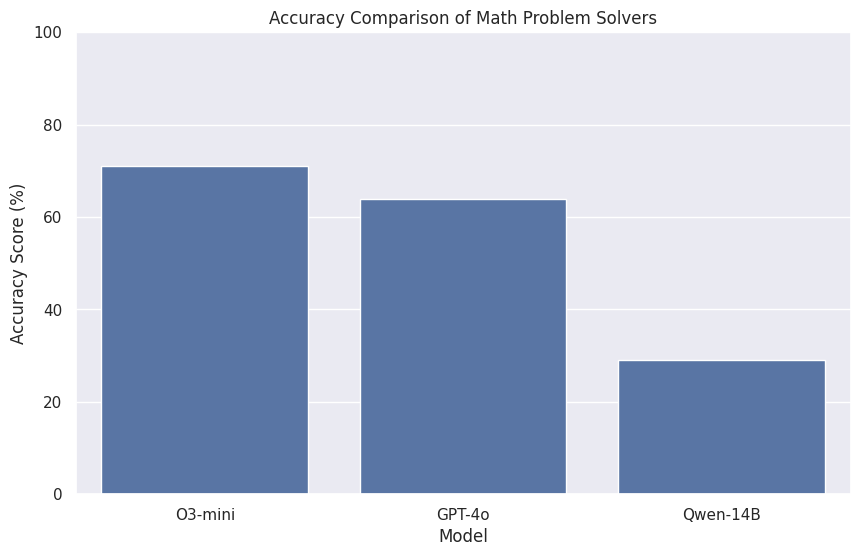

In [76]:
# prompt: Plot a Barplot to visualize and compare the accuracy score of O3-mini, Qwen-14B and GPT-4o arrange in descending order, ensure the maximum value is 100
import matplotlib.pyplot as plt
import seaborn as sns

# Sample accuracy scores (replace with your actual scores)
accuracy_scores = {
    'O3-mini': o3_exec_score,
    'Qwen-14B': qwen_exec_score,
    'GPT-4o': gpt4_exec_score
}

# Sort the models by accuracy score in descending order
sorted_models = dict(sorted(accuracy_scores.items(), key=lambda item: item[1], reverse=True))

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_models.keys()), y=list(sorted_models.values()))
plt.ylim(0, 100)  # Set the y-axis limit to 100
plt.xlabel("Model")
plt.ylabel("Accuracy Score (%)")
plt.title("Accuracy Comparison of Math Problem Solvers")
plt.show()

In [77]:
answer_formats = [entry.get(k).get("answer") for k in entry.keys()]

In [78]:
answer_formats[:4]

['14.1%', '1.3%', '-32%', '-26.16%']

In [79]:
percentage_formats_idx = [
    i for i, a in enumerate(answer_formats) if bool(re.match(r"^-?\d+(\.\d+)?%$", a))
]

In [80]:
percentage_formats_idx[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 11]

In [81]:
entry.get("8").get("exe_ans"), entry.get("8").get("answer")

(0.22986, '22.99%')

In [82]:
entry.get("8").get("program")

'add(27729, 45161), divide(#0, 317105)'

In [83]:
divide_idx = []
count = 0
for idx in percentage_formats_idx:
  prog = entry.get(str(idx)).get("program")
  last_operation = prog.split("), ")[-1].strip()
  if "divide" in last_operation:
    count += 1
    divide_idx.append(idx)
print(count)

1874


In [84]:
for idx in divide_idx[:10]:
  prog = entry.get(f"{idx}").get("program")
  exe_ans = entry.get(f"{idx}").get("exe_ans")
  answer = entry.get(f"{idx}").get("answer")
  print(f"program: {prog}")
  print(f"exe_ans: {exe_ans}")
  print(f"answer: {answer}\n\n")

program: subtract(206588, 181001), divide(#0, 181001)
exe_ans: 0.14136
answer: 14.1%


program: subtract(9362.2, 9244.9), divide(#0, 9244.9)
exe_ans: 0.01269
answer: 1.3%


program: subtract(5363, 7983), divide(#0, 7983)
exe_ans: -0.3282
answer: -32%


program: add(2530454, 5923147), divide(5923147, #0)
exe_ans: 0.70067
answer: 70.1%


program: subtract(3.7, 3.2), divide(#0, 3.2)
exe_ans: 0.15625
answer: 15.6%


program: subtract(118, 102), divide(#0, 102)
exe_ans: 0.15686
answer: 16%


program: add(27729, 45161), divide(#0, 317105)
exe_ans: 0.22986
answer: 22.99%


program: subtract(498.8, 486.9), divide(#0, 486.9)
exe_ans: 0.02444
answer: 2.4%


program: multiply(1.25, const_1000), divide(707, #0)
exe_ans: 0.5656
answer: 56.6%


program: divide(1697, 16088)
exe_ans: 0.10548
answer: 11%




In [85]:
mul_idx = []
count = 0
for idx in percentage_formats_idx:
  prog = entry.get(str(idx)).get("program")
  last_operation = prog.split("), ")[-1].strip()
  if "multiply" in last_operation:
    count += 1
    mul_idx.append(idx)
print(count)

73


In [86]:
for idx in mul_idx[:10]:
  prog = entry.get(f"{idx}").get("program")
  exe_ans = entry.get(f"{idx}").get("exe_ans")
  answer = entry.get(f"{idx}").get("answer")
  print(f"program: {prog}")
  print(f"exe_ans: {exe_ans}")
  print(f"answer: {answer}\n\n")

program: divide(98750, 432000), multiply(#0, const_100)
exe_ans: 22.8588
answer: 22.86%


program: add(1610.3, 1612.9), add(1762.3, 1722.2), divide(#0, #1), multiply(#2, const_100)
exe_ans: 92.50108
answer: 92.5%


program: divide(1881992, 5148881), multiply(#0, const_100)
exe_ans: 36.55148
answer: 36.55%


program: multiply(11.4, const_1000000), multiply(3158226, #0)
exe_ans: 36003776400000.0
answer: 28%


program: add(701, 161), divide(#0, 689), multiply(#1, const_100)
exe_ans: 125.10885
answer: 125.1%


program: divide(687376, 600883), multiply(const_100, #0)
exe_ans: 114.39432
answer: 114%


program: subtract(317, 290), divide(#0, 317), multiply(#1, const_100)
exe_ans: 8.51735
answer: 8.52%


program: subtract(407, 258), divide(#0, 407), multiply(#1, const_100)
exe_ans: 36.60934
answer: 36.61%


program: subtract(22.0, 20.9), divide(#0, 20.9), multiply(#1, const_100)
exe_ans: 5.26316
answer: 5.26%


program: multiply(2, 7)
exe_ans: 14.0
answer: 28.6%




In [87]:
def program_score(model_response, ref_response):
  score = 0
  for key in range(100):
    str_key = str(key)
    if str_key not in model_response:
      print(f"Key not found: {key}\n")
      continue

    pred_entry = model_response.get(str_key)

    if pred_entry and pred_entry.get("program"):
      pred_program = pred_entry.get("program")
      res_program = ref_response[str_key]["program"]
      prog_equality = equal_program(
          program_tokenization(pred_program),
          program_tokenization(res_program)
          )

      if prog_equality:
        score += 1

      else:
        list_program = str_prog_list(pred_program)
        exe_ans = ref_response.get(str_key).get("exe_ans")

        if exe_ans is None:
          print(f"Original answer not found for key: {key}\n")
          continue

        places = get_decimal_places(exe_ans)
        pred_ans = evaluate_program_safe(list_program, round_places=places)

        format_type = model_response[str_key].get("format")
        if pred_ans and format_type == "%":
          pred_ans = round(pred_ans * 0.01, places)

        if exe_ans == pred_ans and not prog_equality:
          print(f"Execution Accuracy and Program Accuracy Inconsistency: ({key})")
          print(f"Original Answer: {exe_ans}, pred_answer: {pred_ans}")
          print(f"Original Program: {res_program}\nPred Program; {pred_program}\n")

  return score

In [88]:
o3_prog_score = program_score(o3_response, entry)

Execution Accuracy and Program Accuracy Inconsistency: (0)
Original Answer: 0.14136, pred_answer: 0.14136
Original Program: subtract(206588, 181001), divide(#0, 181001)
Pred Program; subtract(206588, 181001), divide(#0, 181001), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (2)
Original Answer: -0.3282, pred_answer: -0.3282
Original Program: subtract(5363, 7983), divide(#0, 7983)
Pred Program; subtract(5363, 7983), divide(#0, 7983), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (6)
Original Answer: 0.15625, pred_answer: 0.15625
Original Program: subtract(3.7, 3.2), divide(#0, 3.2)
Pred Program; subtract(3.7, 3.2), divide(#0, 3.2), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (7)
Original Answer: 0.15686, pred_answer: 0.15686
Original Program: subtract(118, 102), divide(#0, 102)
Pred Program; subtract(118, 102), divide(#0, 102), multiply(#1, const_100)

Execution Accuracy and Program A

In [89]:
print(f"O3-mini Program Accuracy: {o3_prog_score}%")

O3-mini Program Accuracy: 12%


In [90]:
qwen_prog_score = program_score(qwen_response, entry)

Execution Accuracy and Program Accuracy Inconsistency: (0)
Original Answer: 0.14136, pred_answer: 0.14136
Original Program: subtract(206588, 181001), divide(#0, 181001)
Pred Program; subtract(206588, 181001), divide(#0, 181001), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (1)
Original Answer: 0.01269, pred_answer: 0.01269
Original Program: subtract(9362.2, 9244.9), divide(#0, 9244.9)
Pred Program; subtract(9362.2, 9244.9), divide(#0, 9244.9), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (2)
Original Answer: -0.3282, pred_answer: -0.3282
Original Program: subtract(5363, 7983), divide(#0, 7983)
Pred Program; subtract(5363, 7983), divide(#0, 7983), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (7)
Original Answer: 0.15686, pred_answer: 0.15686
Original Program: subtract(118, 102), divide(#0, 102)
Pred Program; subtract(118, 102), divide(#0, 102), multiply(#1, const_100)

Execution Accu

In [91]:
print(f"Qwen-14B Program Accuracy: {qwen_prog_score}%")

Qwen-14B Program Accuracy: 7%


In [92]:
gpt4_prog_score = program_score(gpt4_response, entry)

Execution Accuracy and Program Accuracy Inconsistency: (0)
Original Answer: 0.14136, pred_answer: 0.14136
Original Program: subtract(206588, 181001), divide(#0, 181001)
Pred Program; subtract(206588, 181001), divide(#0, 181001), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (1)
Original Answer: 0.01269, pred_answer: 0.01269
Original Program: subtract(9362.2, 9244.9), divide(#0, 9244.9)
Pred Program; subtract(9362.2, 9244.9), divide(#0, 9244.9), multiply(#1, const_100)

Invalid operation format: divide(#0, 7983
Invalid operation format: subtract(3700, 3200),
divide(#0, 3200),
multiply(#1, const_100)
Execution Accuracy and Program Accuracy Inconsistency: (7)
Original Answer: 0.15686, pred_answer: 0.15686
Original Program: subtract(118, 102), divide(#0, 102)
Pred Program; subtract(118, 102), divide(#0, 102), multiply(#1, const_100)

Execution Accuracy and Program Accuracy Inconsistency: (11)
Original Answer: 0.02444, pred_answer: 0.02444
Original Program:

In [93]:
print(f"GPT4 Program Accuracy: {gpt4_prog_score}%")

GPT4 Program Accuracy: 13%


In [146]:
def adjusted_program_score(model_response, ref_response,
                           pattern = r"^(\w+)\(\s*([#\w%.-]+)\s*,\s*([#\w%.-]+)\s*\)$"):
  score = 0
  correct_index = []
  for key in range(100):
    str_key = str(key)
    if str_key not in model_response:
      print(f"Key not found: {key}\n")
      continue

    if model_response[str_key].get("format") and "%" in model_response[str_key].get("format"):
      list_prog = str_prog_list(model_response[str_key]["program"])
      if all([bool(re.match(pattern, op)) for op in list_prog]):
        list_prog = list_prog[:-1]
        str_prog = prog_str_sequence(list_prog)
        if equal_program(
            program_tokenization(model_response[str_key]["program"]),
            program_tokenization(entry[str_key]["program"])
            ):
            score += 1
            correct_index.append(str_key)
        elif equal_program(
            program_tokenization(str_prog),
            program_tokenization(entry[str_key]["program"])
            ):
            score += 1
            correct_index.append(str_key)
        else:
          print(f"Incorrect Progam: {key}")
          print(f"Pred Program({key}): {model_response[str_key]['program']}")
          print(f"Ref Program({key}): {entry[str_key]['program']}\n")
    else:
      if equal_program(
          program_tokenization(model_response[str_key]["program"]),
          program_tokenization(entry[str_key]["program"])
          ):
          score += 1
          correct_index.append(str_key)
      else:
        print(f"Incorrect Progam: {key}")
        print(f"Pred Program({key}): {model_response[str_key]['program']}")
        print(f"Ref Program({key}): {entry[str_key]['program']}\n")

  adjusted_program_score.correct_index = correct_index
  return score

In [112]:
o3_prog_score = adjusted_program_score(o3_response, entry)

Incorrect Progam: 1
Pred Program(1): 
Ref Program(1): subtract(9362.2, 9244.9), divide(#0, 9244.9)

Incorrect Progam: 3
Pred Program(3): subtract(102.11, 75.95)
Ref Program(3): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 4
Pred Program(4): subtract(75.95, const_100), subtract(102.11, const_100), subtract(#1, #0)
Ref Program(4): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 5
Pred Program(5): add(2530454, 5923147), divide(2530454, #0), multiply(#1, const_100)
Ref Program(5): add(2530454, 5923147), divide(5923147, #0)

Incorrect Progam: 12
Pred Program(12): divide(706985, 1250000), multiply(#0, const_100)
Ref Program(12): multiply(1.25, const_1000), divide(707, #0)

Incorrect Progam: 14
Pred Program(14): divide(258.82, 100), subtract(#0, const_1), multiply(#1, const_100)
Ref Program(14): subtract(258.82

In [113]:
print(f"Adjusted O3-mini Program Accuracy: {o3_prog_score}%")

Adjusted O3-mini Program Accuracy: 57%


In [116]:
o3_prog_corrrect_index = adjusted_program_score.correct_index

In [117]:
qwen_prog_score = adjusted_program_score(qwen_response, entry)

Incorrect Progam: 5
Pred Program(5): subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)
Ref Program(5): add(2530454, 5923147), divide(5923147, #0)

Incorrect Progam: 6
Pred Program(6): subtract(3200, 2300), divide(#0, const_100), subtract(1250, const_10)
Ref Program(6): subtract(3.7, 3.2), divide(#0, 3.2)

Incorrect Progam: 8
Pred Program(8): divide(45161, 317105)
Ref Program(8): add(27729, 45161), divide(#0, 317105)

Incorrect Progam: 9
Pred Program(9): subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)
Ref Program(9): add(4.5, 4.1), add(#0, 3.4)

Incorrect Progam: 10
Pred Program(10): subtract(472, 400), divide(#0, const_100), subtract(1250, const_10)
Ref Program(10): subtract(-50, -31)

Incorrect Progam: 11
Pred Program(11): subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)
Ref Program(11): subtract(498.8, 486.9), divide(#0, 486.9)

Incorrect Progam: 12
Pred Program(12): subtract(200, 100), divide(#0, const_100), subtract(1250, con

In [118]:
print(f"Adjusted QWEN-14B Program Accuracy: {qwen_prog_score}%")

Adjusted QWEN-14B Program Accuracy: 26%


In [119]:
qwen_prog_corrrect_index = adjusted_program_score.correct_index

In [142]:
gpt4_prog_score = adjusted_program_score(gpt4_response, entry)

Incorrect Progam: 3
Pred Program(3): subtract(75.95, 102.11), divide(#0, 102.11), multiply(#1, const_100)
Ref Program(3): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 4
Pred Program(4): subtract(102.11, 75.95), divide(#0, const_100)
Ref Program(4): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 5
Pred Program(5): add(2530454, 5923147), divide(2530454, #0), multiply(#1, const_100)
Ref Program(5): add(2530454, 5923147), divide(5923147, #0)

Incorrect Progam: 12
Pred Program(12): divide(707, 1250), multiply(#0, const_100)
Ref Program(12): multiply(1.25, const_1000), divide(707, #0)

Incorrect Progam: 14
Pred Program(14): subtract(258.82, 100), divide(#0, 100), multiply(#1, const_100)
Ref Program(14): subtract(258.82, const_100), divide(#0, const_100)

Incorrect Progam: 15
Pred Program(15): divide(const_1, 

In [143]:
print(f"Adjusted GPT-4o Program Accuracy: {gpt4_prog_score}%")

Adjusted GPT-4o Program Accuracy: 55%


In [144]:
gpt4_prog_correct_index = adjusted_program_score.correct_index

In [152]:
o3_exec_score

71

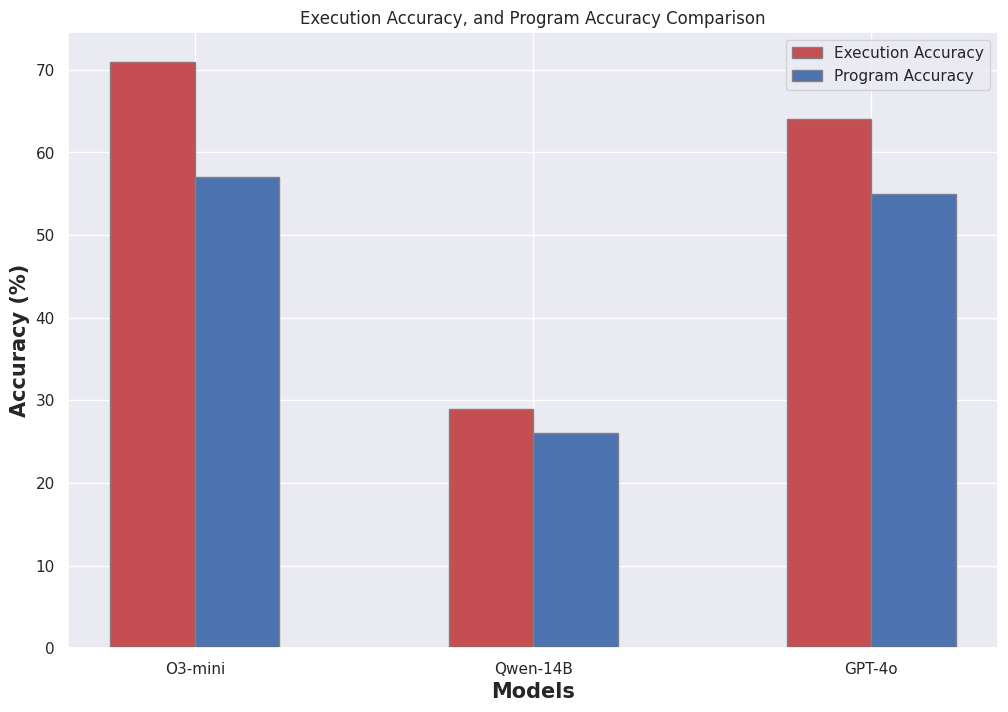

In [153]:
# prompt: plot the execution accuracy and adjusted program accuracy using a compund bar plot. execution accuracy and program accuracy on a separate bar

import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual scores)
models = ['O3-mini', 'Qwen-14B', 'GPT-4o']
execution_accuracy = [o3_exec_score, qwen_exec_score, gpt4_exec_score]  # Replace with your actual execution accuracy values
adjusted_program_accuracy = [o3_prog_score, qwen_prog_score, gpt4_prog_score] # Replace with your actual adjusted program accuracy


# Set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(execution_accuracy))
br2 = [x + barWidth for x in br1]

# Make the plot
plt.bar(br1, execution_accuracy, color ='r', width = barWidth,
        edgecolor ='grey', label ='Execution Accuracy')
plt.bar(br2, adjusted_program_accuracy, color ='b', width = barWidth,
        edgecolor ='grey', label ='Program Accuracy')

# Adding Xticks
plt.xlabel('Models', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth * 0.5 for r in range(len(execution_accuracy))],
        models)

plt.legend()
plt.title("Execution Accuracy, and Program Accuracy Comparison")
plt.show()

In [154]:
o3_correct_index[:10]

['0', '2', '6', '7', '8', '9', '10', '11', '12', '13']

In [158]:
set(o3_correct_index).difference(set(o3_prog_corrrect_index))

{'12',
 '14',
 '23',
 '24',
 '31',
 '40',
 '42',
 '50',
 '54',
 '60',
 '62',
 '72',
 '77',
 '87'}

In [159]:
o3_response.get("12")

{'program': 'divide(706985, 1250000), multiply(#0, const_100)', 'format': '%'}

In [161]:
entry.get("12").get("program")

'multiply(1.25, const_1000), divide(707, #0)'

In [166]:
train_data[12]["table"]

[['', 'class a common stock', 'class b common stock'],
 ['balance at december 31 2016', '2014', '2014'],
 ['issue of shares on business combination at july 3 2017',
  '427709',
  '717111'],
 ['issue of shares upon vesting of restricted stock units ( 1 )',
  '290',
  '2014'],
 ['issue of shares on exercises of stock options ( 1 )', '256', '2014'],
 ['stock repurchase program ( 2 ) ( 3 )',
  '-6047 ( 6047 )',
  '-10126 ( 10126 )'],
 ['balance at december 31 2017', '422208', '706985']]

In [169]:
train_data[12]["qa"]["question"]

'what portion of the authorized shares of class b common stock is outstanding as of december 31 , 2017?'

In [174]:
train_data[12]["qa"]["gold_inds"]

{'text_4': 'equity common stock we are authorized to issue 2 billion shares of class a common stock , 1.25 billion shares of class b common stock and 50 million shares of preferred stock each of which have a par value of $ 0.0001 per share .',
 'text_6': 'the number of class a common stock and class b common stock shares outstanding at december 31 , 2017 is 422 million and 707 million , respectively .'}

In [170]:
def table_to_html(data: list) -> str:
  html = "<table class='wikitable'>"

  for i, row in enumerate(data, start=1):
    html += "<tr><td>{}</td>".format(i) + "".join(f"<td>{cell}</td>" for cell in row) + "</tr>"
  html += "</table>"

  return html

In [171]:
def financial_report_html(entry: dict) -> str:
  pre_text = " ".join(entry.get("pre_text"))
  post_text = " ".join(entry.get("post_text"))
  table = entry.get("table")

  html = f"""
              <div>
                <p>{pre_text}</p>
              </div>
              <div>
                {table_to_html(table)}
              </div>
              <div>
                <p>{post_text}</p>
              </div>
  """

  return html

In [173]:
HTML(financial_report_html(train_data[12]))

1,,class a common stock,class b common stock
2,balance at december 31 2016,2014,2014
3,issue of shares on business combination at july 3 2017,427709,717111
4,issue of shares upon vesting of restricted stock units ( 1 ),290,2014
5,issue of shares on exercises of stock options ( 1 ),256,2014
6,stock repurchase program ( 2 ) ( 3 ),-6047 ( 6047 ),-10126 ( 10126 )
7,balance at december 31 2017,422208,706985


In [179]:
entry.get("59")["program"].split("), ")

['subtract(45296, 41895', 'divide(#0, 41895)']

In [183]:
prog_len = [len(entry.get(key)["program"].split("), ")) for key in entry]

In [185]:
prog_len[:10]

[2, 2, 2, 5, 5, 2, 2, 2, 2, 2]

In [188]:
len(prog_len)

3037

In [205]:
dct = dict()
for i, v in enumerate(prog_len[:100]):
  dct[v] = dct.get(v, []) + [i]

In [229]:
o3_cnt_dct = dict()
for ind in o3_correct_index:
  for i in dct.keys():
    if int(ind) in dct[i]:
      o3_cnt_dct[i] = o3_cnt_dct.get(i, 0) + 1

In [227]:
gpt4_cnt_dct = dict()
for ind in gpt4_correct_index:
  for i in dct.keys():
    if int(ind) in dct[i]:
      gpt4_cnt_dct[i] = gpt4_cnt_dct.get(i, 0) + 1

In [230]:
qwen_cnt_dct = dict()
for ind in qwen_correct_index:
  for i in dct.keys():
    if int(ind) in dct[i]:
      qwen_cnt_dct[i] = qwen_cnt_dct.get(i, 0) + 1

In [225]:
rounds_cnt = {k:len(v) for k, v in dct.items()}

In [233]:
rounds_cnt

{2: 77, 5: 5, 1: 13, 3: 5}

In [228]:
gpt4_cnt_dct

{2: 52, 1: 10, 3: 2}

In [231]:
qwen_cnt_dct

{2: 23, 5: 3, 1: 2, 3: 1}

In [232]:
o3_cnt_dct

{2: 55, 1: 11, 3: 4, 5: 1}

In [237]:
23 * 100 / 77

29.87012987012987

In [245]:
models = ["o3-mini"] * 4 + ["qwen"] * 4 + ["gpt4"] * 4
program_steps = [1, 2, 3, 5] + [1, 2, 3, 5] + [1, 2, 3, 5]

In [246]:
ratio = []
for model in [o3_cnt_dct, qwen_cnt_dct, gpt4_cnt_dct]:
  for step in [1, 2, 3, 5]:
    ratio.append(model.get(step, 0) / rounds_cnt[step])

In [247]:
len(ratio)

12

In [249]:
ratio_df = pd.DataFrame(data = {
    "model": models,
    "program_step": program_steps,
    "ratio": ratio
})

In [256]:
ratio_df.sort_values(by=["program_step", "ratio"], ascending = [True, False], inplace=True)

In [257]:
ratio_df

,model,program_step,ratio
0,o3-mini,1,0.846154
8,gpt4,1,0.769231
4,qwen,1,0.153846
1,o3-mini,2,0.714286
9,gpt4,2,0.675325
5,qwen,2,0.298701
2,o3-mini,3,0.800000
10,gpt4,3,0.400000
6,qwen,3,0.200000
7,qwen,5,0.600000


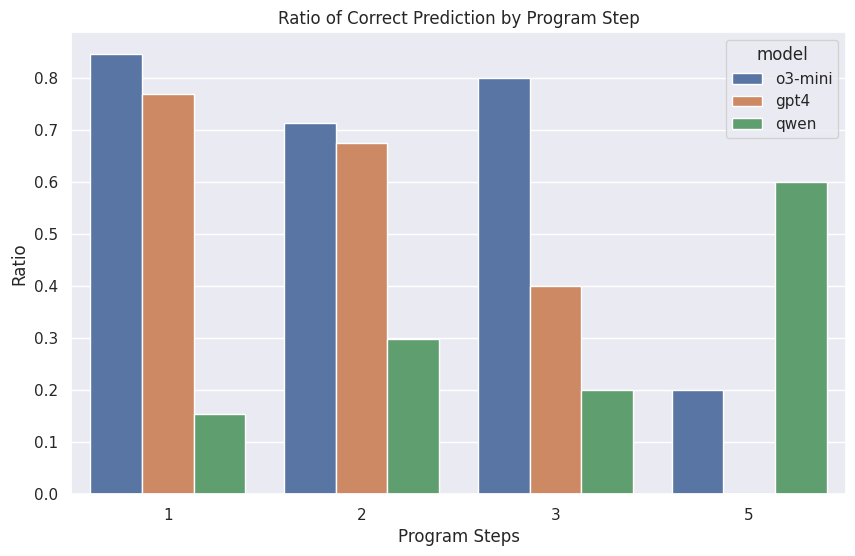

In [259]:
# prompt: Plot a grouped bar chart for ratio_df. group model for each program step.

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ratio_df is already created as in the provided code

plt.figure(figsize=(10, 6))
sns.barplot(x='program_step', y='ratio', hue='model', data=ratio_df)
plt.xlabel('Program Steps')
plt.ylabel('Ratio')
plt.title('Ratio of Correct Prediction by Program Step')
plt.show()


In [263]:
dct[1]

[10, 13, 15, 16, 40, 41, 52, 57, 72, 76, 89, 95, 98]

In [317]:
set(dct[5]).difference([int(i) for i in qwen_correct_index])

{78, 99}

In [321]:
qwen_response.get("99")

{'program': 'subtract(200, 100), divide(#0, const_100), subtract(1250, const_10)',
 'format': '%'}

In [322]:
train_data[99].get("qa")

{'question': 'what was the difference in percentage cumulative total shareowners 2019 returns for united parcel service inc . versus the standard & poor 2019s 500 index for the five years ended 12/31/10?',
 'answer': '-1.42%',
 'explanation': '',
 'ann_table_rows': [1, 2],
 'ann_text_rows': [],
 'steps': [{'op': 'minus2-1',
   'arg1': '110.57',
   'arg2': 'const_100',
   'res': '10.57'},
  {'op': 'divide2-2', 'arg1': '#0', 'arg2': 'const_100', 'res': '10.57%'},
  {'op': 'minus2-3', 'arg1': '111.99', 'arg2': 'const_100', 'res': '11.99'},
  {'op': 'divide2-4', 'arg1': '#2', 'arg2': 'const_100', 'res': '11.99%'},
  {'op': 'minus2-5', 'arg1': '#1', 'arg2': '#3', 'res': '-1.42%'}],
 'program': 'subtract(110.57, const_100), divide(#0, const_100), subtract(111.99, const_100), divide(#2, const_100), subtract(#1, #3)',
 'gold_inds': {'table_1': 'the united parcel service inc . of 12/31/05 is $ 100.00 ; the united parcel service inc . of 12/31/06 is $ 101.76 ; the united parcel service inc . of 

In [289]:
entry["24"]

{'question': 'what was the difference in cumulative percentage returns between edwards lifesciences and the s&p 500 for the five years ended 2016?',
 'answer': '67%',
 'program': 'subtract(265.06, const_100), divide(#0, const_100), subtract(198.18, const_100), divide(#2, const_100), subtract(#1, #3)',
 'exe_ans': 0.6688,
 'pre_text': ['2mar201707015999 ( c ) in october 2016 , our accelerated share repurchase ( 2018 2018asr 2019 2019 ) agreement concluded and we received an additional 44 thousand shares of our common stock .',
  'shares purchased pursuant to the asr agreement are presented in the table above in the periods in which they were received .',
  'performance graph the following graph compares the performance of our common stock with that of the s&p 500 index and the s&p 500 healthcare equipment index .',
  'the cumulative total return listed below assumes an initial investment of $ 100 at the market close on december 30 , 2011 and reinvestment of dividends .',
  'comparison o

In [314]:
full_dct = dict()
for i, v in enumerate(prog_len):
  full_dct[v] = full_dct.get(v, []) + [i]

In [316]:
{k:len(v) for k, v in full_dct.items()}

{2: 2107, 5: 43, 1: 571, 3: 283, 4: 33}

In [155]:
_ = evaluate_responses(o3_response, entry)

Program not found
Original Answer: -0.2616
o3_pred: 0.2616

Original Answer: -0.2616
o3_pred: 0.2616

Original Answer: 0.70067
o3_pred: 0.29933

Invalid argument: C
Error processing key 15: unsupported operand type(s) for -: 'float' and 'NoneType'
Original Answer: 0.0228
o3_pred: 0.1515

Original Answer: -0.13249
o3_pred: 0.13249

Original Answer: -0.56939
o3_pred: -56.93872

Original Answer: -0.13397
o3_pred: 0.13397

Original Answer: 0.17647
o3_pred: -0.15

Original Answer: -0.76786
o3_pred: 0.76786

Original Answer: -0.14903
o3_pred: 169.0

Original Answer: 0.49296
o3_pred: 0.55336

Original Answer: 0.47419
o3_pred: 294.0

Original Answer: -1281.0
o3_pred: 0.5

Original Answer: 0.685
o3_pred: 0.937

Original Answer: 0.67385
o3_pred: 0.86957

Program not found
Original Answer: -0.0637
o3_pred: 0.0637

Original Answer: 0.25432
o3_pred: 2973.0

Original Answer: 2484034.0
o3_pred: 1200000000.0

Original Answer: 0.48
o3_pred: 0.62

Original Answer: 0.01803
o3_pred: 0.02002

Original Answ

In [156]:
_ = adjusted_program_score(o3_response, entry)

Incorrect Progam: 1
Pred Program(1): 
Ref Program(1): subtract(9362.2, 9244.9), divide(#0, 9244.9)

Incorrect Progam: 3
Pred Program(3): subtract(102.11, 75.95)
Ref Program(3): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 4
Pred Program(4): subtract(75.95, const_100), subtract(102.11, const_100), subtract(#1, #0)
Ref Program(4): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

Incorrect Progam: 5
Pred Program(5): add(2530454, 5923147), divide(2530454, #0), multiply(#1, const_100)
Ref Program(5): add(2530454, 5923147), divide(5923147, #0)

Incorrect Progam: 12
Pred Program(12): divide(706985, 1250000), multiply(#0, const_100)
Ref Program(12): multiply(1.25, const_1000), divide(707, #0)

Incorrect Progam: 14
Pred Program(14): divide(258.82, 100), subtract(#0, const_1), multiply(#1, const_100)
Ref Program(14): subtract(258.82

In [157]:
o3_correct_index = evaluate_responses.correct_index

In [158]:
o3_prog_corrrect_index = adjusted_program_score.correct_index

In [159]:
o3_correct_index[:10]

['0', '2', '6', '7', '8', '9', '10', '11', '12', '13']

In [160]:
o3_prog_corrrect_index[:10]

['0', '2', '6', '7', '8', '9', '10', '11', '13', '16']

In [161]:
set(o3_prog_corrrect_index).difference(set(o3_correct_index))

set()

In [162]:
set(o3_correct_index).difference(o3_prog_corrrect_index)

{'12',
 '14',
 '23',
 '24',
 '31',
 '40',
 '42',
 '50',
 '54',
 '60',
 '62',
 '72',
 '77',
 '87'}

In [167]:
o3_response.get("77").get("program")

'divide(4400, 6700), multiply(#0, const_100)'

In [168]:
entry.get("77").get("program")

'multiply(4.4, const_1000), divide(#0, 6700)'

In [143]:
evaluate_program_safe(str_prog_list(o3_response.get("25").get("program")))

83.6485

In [144]:
entry.get("25").get("answer")

'83.6%'

In [145]:
entry.get("25").get("exe_ans")

0.83648

In [ ]:
# prompt: find equality between two floats to the nearest thousandth

def nearly_equal(a, b, tolerance=0.001):
  """
  Checks if two floats are equal to the nearest thousandth.
  """
  return abs(a - b) < tolerance


In [162]:
prog_12 = o3_response.get("12").get("program")
exe_prog_12 = entry.get("12").get("program")

In [163]:
equal_program(
    program_tokenization(prog_12),
    program_tokenization(exe_prog_12)
)

False

In [103]:
o3_response["45"]["program"].split("),")[:-1]

'subtract(5051, 4694), divide(#0, 4694), multiply(#1, const_100)'

In [99]:
op = "add(34, const_55)"

In [101]:
bool(
    re.match(r"^(\w+)\(\s*([#\w%.-]+)\s*,\s*([#\w%.-]+)\s*\)$",
             op)
)

True

In [105]:
str_prog_list(o3_response["45"]["program"])[:-1]

['subtract(5051, 4694)', 'divide(#0, 4694)']

In [108]:
prog_str_sequence(str_prog_list(o3_response["45"]["program"])[:-1])

'subtract(5051, 4694), divide(#0, 4694)'

In [67]:
entry["56"]["program"]

'subtract(73501, 50583), divide(#0, 50583)'

True

In [110]:
prog_1 = "multiply(456, 100), divide(#0, 750), divide(120, 150), multiply(#2, 100), add(#3, #1), subtract(100, #4)"
prog_2 = "divide(456, 750), multiply(#0, 100), multiply(120, 100), divide(#2, 150), add(#1, #3), subtract(100, #4)"

In [111]:
equal_program(program_tokenization(prog_1),
              program_tokenization(prog_2))

True

In [88]:
o3_progs["4"]

'subtract(75.95, const_100), subtract(102.11, const_100), subtract(#1, #0)'

In [92]:
o3_progs["4"]

'subtract(75.95, const_100), subtract(102.11, const_100), subtract(#1, #0)'

In [89]:
entry["4"]["program"]

'subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)'

In [93]:
score = 0
for i in range(100):
  if str(i) not in o3_progs:
    print(f"Index {i} not found")
  else:
    pred_tokens = program_tokenization(o3_progs[str(i)])
    ref_tokens = program_tokenization(entry[str(i)]["program"])

    if equal_program(pred_tokens, ref_tokens):
      score += 1
    else:
      print(f"O3-mini Program({i}): {o3_progs[str(i)]}")
      print(f"Ref Program({i}): {entry[str(i)]['program']}\n")

O3-mini Program(0): subtract(206588, 181001), divide(#0, 181001), multiply(#1, const_100)
Ref Program(0): subtract(206588, 181001), divide(#0, 181001)

O3-mini Program(1): 
Ref Program(1): subtract(9362.2, 9244.9), divide(#0, 9244.9)

O3-mini Program(2): subtract(5363, 7983), divide(#0, 7983), multiply(#1, const_100)
Ref Program(2): subtract(5363, 7983), divide(#0, 7983)

O3-mini Program(3): subtract(102.11, 75.95)
Ref Program(3): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

O3-mini Program(4): subtract(75.95, const_100), subtract(102.11, const_100), subtract(#1, #0)
Ref Program(4): subtract(75.95, const_100), divide(#0, const_100), subtract(102.11, const_100), divide(#2, const_100), subtract(#1, #3)

O3-mini Program(5): add(2530454, 5923147), divide(2530454, #0), multiply(#1, const_100)
Ref Program(5): add(2530454, 5923147), divide(5923147, #0)

O3-mini Program(6): subtract(3.7, 3.2), divide(#0, 3.2), multiply

In [94]:
score

12

In [54]:
candidates = {}
for id in range(len(nbest_predictions)):
  ref_program = nbest_predictions[str(id)][0]["ref_prog"]
  pred_program = nbest_predictions[str(id)][0]["pred_prog"]
  ref_answer = nbest_predictions[str(id)][0]["ref_answer"]

  if len(pred_program) == 2 and bool(re.match(r"^-?\d*\.?\d+%?$", pred_program[0])):
    # print(f"Single Word({id}): {pred_program}")
    if "%" in pred_program[0]:
      pred_answer = float(pred_program[0].replace("%", "")) / 100
    else:
      pred_answer = float(pred_program[0])
  else:
    try:
      if "EOF" not in pred_program:
        pred_program += [")", "EOF"]
      pred_prog = detokenize(pred_program)
    except:
      print(f"Error detokenizing: {pred_program}")
      continue
    try:
      pred_prog = str_prog_list(pred_prog)
    except:
      print(f"Error str_prog_list: {pred_program}")
      continue
    try:
      pred_answer = evaluate_program_safe(pred_prog)
    except:
      print(f"Error evaluate_program_safe: {pred_program}")
      pred_answer = None

  if pred_answer:
    try:
      prog_equality = equal_program(pred_program, ref_program)
    except:
        print(f"Error equal_program: {pred_program}")
        print(f"Error equal_program: {ref_program}")
        continue
    if pred_answer != ref_answer and prog_equality:
      print("\n\n")
      print(f"Pred Program({id}): {pred_program}")
      print(f"Ref Program({id}): {ref_program}\n")
      print("\n\n")
      continue

Invalid operation format: 
Error detokenizing: ['multiply(', '45', ')', 'EOF']
Error detokenizing: ['multiply(', '1.3', ')', 'EOF']



Pred Program(252): ['greater(', '36197', '345059', ')', 'EOF']
Ref Program(252): ['greater(', '36197', '345059', ')', 'EOF']




Error detokenizing: ['subtract(', '22.8', '27.4', ')', 'divide(', '#0', 'multiply(', '#0', '27.4', ')', 'multiply(', '#1', 'const_100', ')', 'EOF']
Error detokenizing: ['multiply(', '1.9', ')', 'EOF']
Error detokenizing: ['multiply(', '932', ')', 'EOF']
Error detokenizing: ['multiply(', '41', ')', 'EOF']
Error detokenizing: ['multiply(', '41', ')', 'EOF']
Error detokenizing: ['multiply(', '1000', ')', 'EOF']
Error detokenizing: ['multiply(', '1000', ')', 'EOF']
